## Исходный датасет
*4 часа (долгая обработка + пришлось добавлять параллельное выполнение)*

In [1]:
import numpy as np
import pandas as pd
from faker import Faker
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt
import multiprocessing as mp

In [2]:
# параметры
num_records = 10_000_000  # кол-во записей (на 100 млн крашится юпитер при формировании датафрейма, оптимизировал как мог) 
duplicate_ratio = 0.1     # процент дублей
num_workers = 10          # кол-во воркеров (опционально)
batch_size = num_records // num_workers


# инициализация Faker
fake = Faker()
# генерация числовых данных
numeric_data = np.random.randint(0, 1000, num_records)

print(f"Размер пачки на 1 воркера: {batch_size}")

Размер пачки на 1 воркера: 1000000


In [3]:
# генерация дат (потребляет относительно немного ресурсов, поэтому не стал добавлять параллельность)
start_date = datetime(2015, 1, 1)
end_date = datetime(2023, 1, 1)
date_range = (end_date - start_date).days
date_data = [start_date + timedelta(days=np.random.randint(0, date_range)) for _ in range(num_records)]
# TODO добавить параллельную генерацию

In [4]:
print(date_data[:10])  # вывод первых 10 дат


[datetime.datetime(2018, 5, 4, 0, 0), datetime.datetime(2020, 3, 13, 0, 0), datetime.datetime(2015, 6, 6, 0, 0), datetime.datetime(2019, 9, 15, 0, 0), datetime.datetime(2022, 7, 23, 0, 0), datetime.datetime(2016, 4, 15, 0, 0), datetime.datetime(2017, 12, 12, 0, 0), datetime.datetime(2019, 1, 6, 0, 0), datetime.datetime(2020, 8, 26, 0, 0), datetime.datetime(2016, 2, 27, 0, 0)]


In [5]:
def generate_names(batch_size):
    return [fake.name() for _ in range(batch_size)]

# генерим данные в несколько потоков (иначе у меня крашился юпитер)
if __name__ == '__main__':
    with mp.Pool(processes=num_workers) as pool:
        results = pool.map(generate_names, [batch_size] * num_workers)

# мержим в один список
string_data = [name for sublist in results for name in sublist]

print(string_data[:10])  # вывод первых 10 имен

['Brian Morris', 'Michael Carter', 'Brian James', 'Billy Herrera', 'Dawn Stewart', 'Roger Craig', 'Cheryl Johnson', 'Michelle Joseph', 'Jason Meadows', 'Joshua Williams']


In [6]:
# len(numeric_data)
# len(date_data)
# len(string_data)

In [7]:
# формируем датафрейм
df = pd.DataFrame({
    'numeric': numeric_data,
    'date': date_data,
    'string': string_data
})

In [8]:
# df.head(5)
# df.tail(5)

In [9]:
# дублируем значения
num_duplicates = int(num_records * duplicate_ratio)
duplicates = df.sample(num_duplicates)
df = pd.concat([df, duplicates], ignore_index=True)

In [10]:
len(df)

11000000

In [11]:
# выгружаем в csv
csv_filename = 'dataset.csv'
df.to_csv(csv_filename, index=False)

In [12]:
# выгружаем в json (опционально)
# json_filename = 'dataset.json'
# df.to_json(json_filename, orient='records', lines=True)

In [13]:
print(f"Датасет создан с {len(df)} записями, включая {num_duplicates} дублей.")
print(f"Файлы сохранены как {csv_filename}.")
print(f"Первые 5 строк: \n{df.head(5)}")

Датасет создан с 11000000 записями, включая 1000000 дублей.
Файлы сохранены как dataset.csv.
Первые 5 строк: 
   numeric       date          string
0      197 2018-05-04    Brian Morris
1      685 2020-03-13  Michael Carter
2      962 2015-06-06     Brian James
3      662 2019-09-15   Billy Herrera
4      802 2022-07-23    Dawn Stewart


---

## Считывание и процессинг

In [14]:
# считываем данные
file_path = 'dataset.csv' # путь к файлу
df = pd.read_csv(file_path)

In [15]:
# удаляем пустые строки
def remove_na(df):
    return df.dropna()

In [16]:
# удаляем дубли
def remove_duplicates(df):
    return df.drop_duplicates()

In [17]:
# делаем из строк без цифр пустые строки
def remove_non_numeric_strings(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: '' if not re.search(r'\d', str(x)) else x) # если в x есть хоть одна цифра то True
    return df

In [18]:
# удаляем записи в промежутке от 1 до 3 часов ночи
def remove_time_interval(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name])
    return df[~((df[column_name].dt.hour >= 1) & (df[column_name].dt.hour < 3))]

In [19]:
# ПОСЛЕДОВАТЕЛЬНО обрабатываем данные (параллельно не получилось)
df = remove_na(df)
df = remove_duplicates(df)
df = remove_non_numeric_strings(df, column_name='string')
df = remove_time_interval(df, column_name='date')

In [20]:
# *Параллельная обработка* данных
# TODO

In [21]:
# Сохранение обработанных данных
df.to_csv('processed_dataset.csv', index=False)

In [22]:
print("Обработка завершена.")

Обработка завершена.


---

## Расчет метрик

In [23]:
# считываем данные
file_path = 'processed_dataset.csv'
df = pd.read_csv(file_path)


In [24]:
# парсим в datetime
df['date'] = pd.to_datetime(df['date'])
df['date'].head(5)

0   2018-05-04
1   2020-03-13
2   2015-06-06
3   2019-09-15
4   2022-07-23
Name: date, dtype: datetime64[ns]

In [25]:
# создаем поле hour
df['hour'] = df['date'].dt.hour
df['hour'].head(5) # TODO

0    0
1    0
2    0
3    0
4    0
Name: hour, dtype: int32

In [26]:
# проверка на пропущенные значения numeric
df['numeric'] = pd.to_numeric(df['numeric'], errors='coerce')
print("Есть ли пропущенные значения в 'numeric':", df['numeric'].isnull().any())

# удаляем строки с пропущенными значениями 
df = df.dropna(subset=['numeric'])

Есть ли пропущенные значения в 'numeric': False


In [27]:
# агрегация по часам
aggregated_df = df.groupby('hour').agg(
    unique_strings=('string', 'nunique'),
    mean_numeric=('numeric', 'mean'),
    median_numeric=('numeric', 'median')
).reset_index()

In [28]:
# сохраняем
aggregated_df.to_csv('aggregated_metrics.csv', index=False)

In [29]:
print(aggregated_df) # TODO сделать правильный datetime


   hour  unique_strings  mean_numeric  median_numeric
0     0               0    499.410001           499.0


In [30]:
print("Агрегация завершена.")

Агрегация завершена.


```SQL
-- sql запрос для агрегации данных (валиден для ClickHouse)
SELECT
    toHour(date) AS hour,
    countDistinct(string) AS unique_strings,
    avg(numeric) AS mean_numeric,
    median(numeric) AS median_numeric
FROM
    table_name GROUP BY toHour(date) ORDER BY hour;
```

---

## Мерж с метриками
*1 час*

In [31]:
# Считывание данных
df = pd.read_csv('dataset.csv')
metrics = pd.read_csv('aggregated_metrics.csv')


In [32]:
# выносим в отдельное поле
df['date'] = pd.to_datetime(df['date'])
df['hour'] = df['date'].dt.hour


In [33]:
# Переименовываем столбец в метриках для предотвращения конфликта имен
metrics.rename(columns={'hour': 'metric_hour'}, inplace=True)


In [34]:
# Мерж по часам
df = df.merge(metrics, left_on='hour', right_on='metric_hour', how='left')


In [35]:
# дропаем временный столбец
df.drop(columns=['metric_hour'], inplace=True)


In [36]:
# сохраняем
df.to_csv('merged_dataset.csv', index=False)


In [37]:
print("Мерж завершен.")
df.head(10)

Мерж завершен.


,numeric,date,string,hour,unique_strings,mean_numeric,median_numeric
0,197,2018-05-04,Brian Morris,0,0,499.410001,499.0
1,685,2020-03-13,Michael Carter,0,0,499.410001,499.0
2,962,2015-06-06,Brian James,0,0,499.410001,499.0
3,662,2019-09-15,Billy Herrera,0,0,499.410001,499.0
4,802,2022-07-23,Dawn Stewart,0,0,499.410001,499.0
5,182,2016-04-15,Roger Craig,0,0,499.410001,499.0
6,45,2017-12-12,Cheryl Johnson,0,0,499.410001,499.0
7,890,2019-01-06,Michelle Joseph,0,0,499.410001,499.0
8,836,2020-08-26,Jason Meadows,0,0,499.410001,499.0
9,852,2016-02-27,Joshua Williams,0,0,499.410001,499.0


---

## Аналитические метрики
*0.5 часа*

In [38]:
# считываем данные
file_path = 'merged_dataset.csv' 
df = pd.read_csv(file_path)

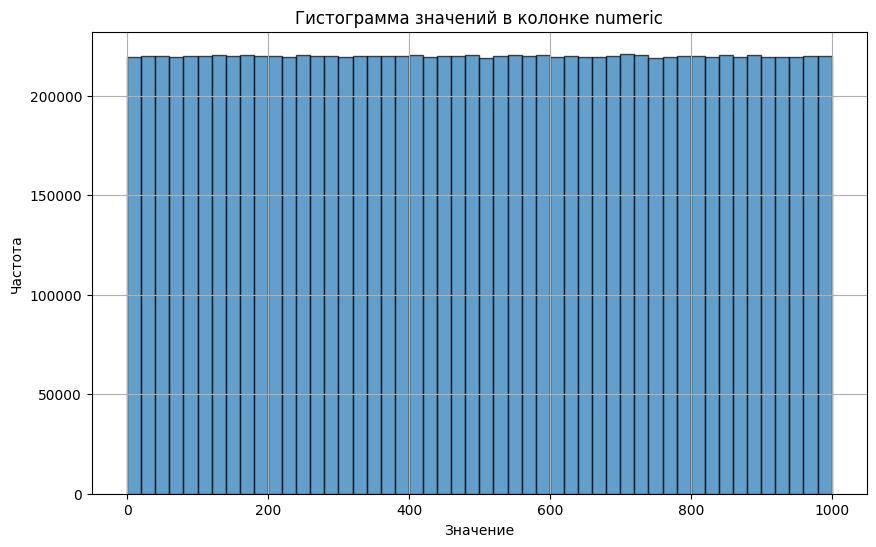

In [39]:
# гисторгамма по numeric
plt.figure(figsize=(10, 6))
plt.hist(df['numeric'].dropna(), bins=50, edgecolor='k', alpha=0.7)
plt.title('Гистограмма значений в колонке numeric')
plt.xlabel('Значение')
plt.ylabel('Частота')
plt.grid(True)
plt.show()


In [40]:
# доверительный интервал
# не сделал

---

## Визуализация 
*(1.5 часа)*

In [41]:
# график среднего значения numeric по месяцам
# создаем столбцы для года и месяца
df['date'] = pd.to_datetime(df['date'])
df['year_month'] = df['date'].dt.to_period('M')


In [42]:
# группируем по году и месяцу и считаем среднее значения
monthly_mean = df.groupby('year_month')['numeric'].mean().reset_index()
monthly_mean.head(5)

,year_month,numeric
0,2015-01,498.295795
1,2015-02,499.653644
2,2015-03,500.423920
3,2015-04,499.079779
4,2015-05,499.193454


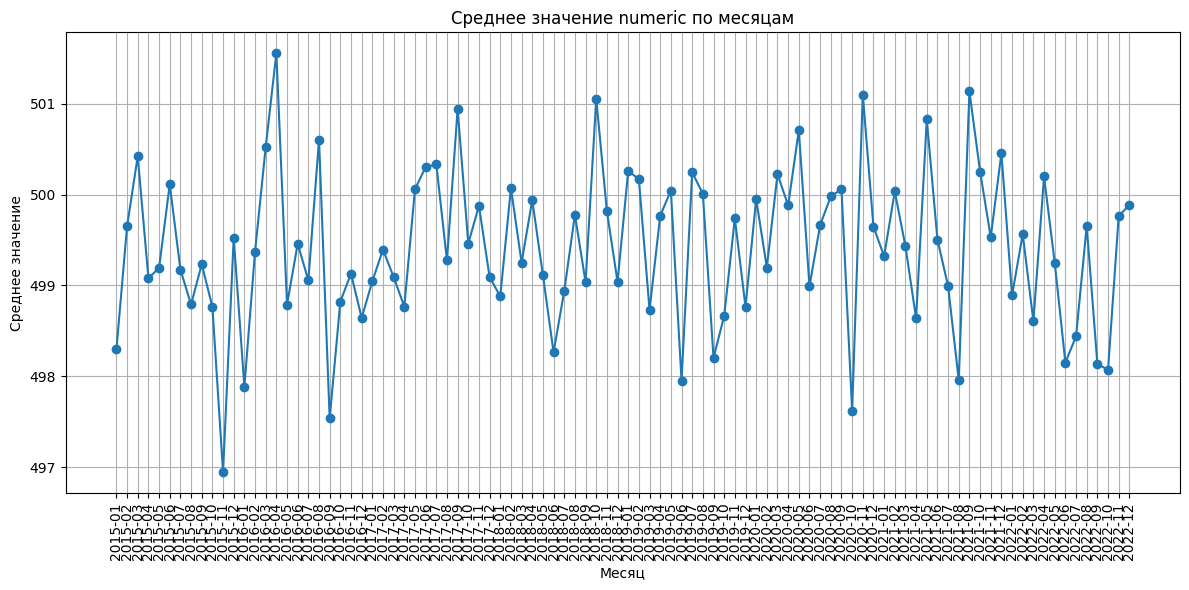

In [43]:
# график
plt.figure(figsize=(12, 6))
plt.plot(monthly_mean['year_month'].astype(str), monthly_mean['numeric'], marker='o', linestyle='-')
plt.title('Среднее значение numeric по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Среднее значение')
plt.xticks(rotation=90)
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
# heatmap по частотности символов в колонке string
# мержим строки в одну
all_strings = ' '.join(df['string'].dropna())


In [45]:
# считаем частотность
char_freq = pd.Series(list(all_strings)).value_counts().reset_index()
char_freq.columns = ['Character', 'Frequency']


In [46]:
# сортируем по символам 
char_freq = char_freq.sort_values(by='Frequency', ascending=False)
char_freq.head(5)

,Character,Frequency
0,,22488675
1,e,13583007
2,a,13482308
3,n,10987829
4,r,10514599


In [47]:
# парсим в матричный вид
char_matrix = pd.DataFrame({'Frequency': char_freq['Frequency'].values}, index=char_freq['Character'])
char_matrix.head(5)

,Frequency
Character,
,22488675
e,13583007
a,13482308
n,10987829
r,10514599


In [48]:
# преобразуем в 2д массив
max_chars = 20  # ков-во символов по оси х
if len(char_matrix) < max_chars:
    char_matrix = char_matrix.reindex(range(max_chars), fill_value=0)

In [49]:
# преобразуем char_matrix в матрицу
matrix_data = char_matrix.T.values
print(matrix_data)

[[22488675 13583007 13482308 10987829 10514599  8838684  7873935  7418428
   6582180  5072793  4911248  3321929  2984199  2834393  2642966  2555828
   2251280  1953016  1871840  1712914  1534244  1422479  1410997  1394082
   1309246  1141062  1126701  1080175  1051056  1046160   981096   980604
    967715   954905   931583   906335   822961   819649   628229   531751
    415349   411771   293253   233331   200523   170785    92604    79883
     73846    66730    57435     7469     5693     2407]]


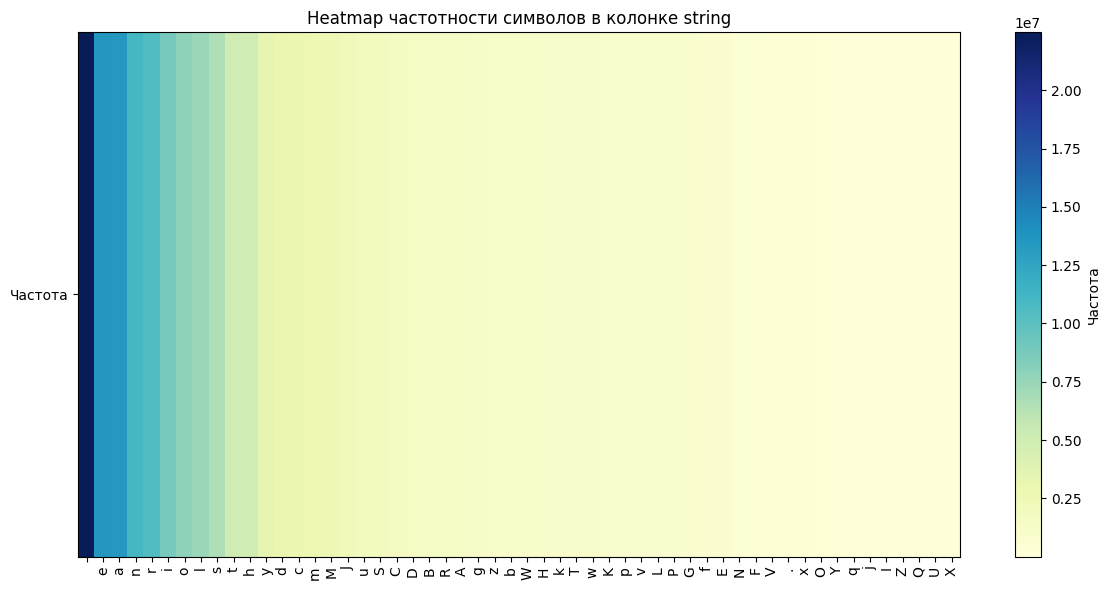

In [50]:
# Построение тепловой карты
plt.figure(figsize=(12, 6))
plt.imshow(matrix_data, cmap='YlGnBu', aspect='auto')
plt.colorbar(label='Частота')
plt.xticks(ticks=np.arange(len(char_matrix)), labels=char_matrix.index, rotation=90)
plt.yticks(ticks=[0], labels=['Частота'])
plt.title('Heatmap частотности символов в колонке string')
plt.tight_layout()
plt.show()
